In [ ]:
!pip install d2l==1.0.0-beta0

Mặc dù chúng ta đã mô tả mỗi tấm ảnh được tạo nên bởi nhiều kênh (channel) (cụ thể, ảnh màu sử dụng hệ màu RGB tiêu chuẩn với các kênh riêng biệt thể hiện lượng màu đỏ, xanh lá và xanh dương), nhưng cho đến lúc này, ta vẫn đơn giản hóa tất cả các ví dụ tính toán với chỉ một kênh đầu vào và một kênh đầu ra. Điều đó đã cho phép chúng ta coi các đầu vào, các bộ lọc tích chập và các đầu ra như các mảng hai chiều.

Khi chúng ta thêm các kênh vào hỗn hợp ấy, đầu vào cùng với các lớp biểu diễn ẩn của ta trở thành các mảng ba chiều. Chẳng hạn, mỗi ảnh RGB đầu vào có dạng $3×h×w$. Ta xem trục này là chiều kênh, có kích thước là 3. Trong phần này, ta sẽ quan sát sâu hơn vào các bộ lọc tích chập với đầu vào và đầu ra đa kênh.

In [ ]:
import torch
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# 7.4.1. Đa kênh Đầu vào.

Khi dữ liệu đầu vào có nhiều kênh, ta cần xây dựng một bộ lọc tích chập với cùng số kênh đầu vào như dữ liệu nhập, để nó có thể thực hiện tính tương quan chéo với dữ liệu này. Giả sử số kênh dữ liệu đầu vào là  $c_i$, ta sẽ cần số kênh đầu vào của bộ lọc tích chập là $c_i$. Nếu kích thước cửa sổ của bộ lọc tích chập là $k_h×k_w$, thì khi $c_i=1$, ta có thể xem bộ lọc tích chập này đơn giản là một mảng hai chiều có kích thước $k_h×k_w$.

Tuy nhiên, khi $c_i>1$, chúng ta cần một bộ lọc chứa mảng có kích thước $k_h×k_w$ cho mỗi kênh của đầu vào. Gộp $c_i$ mảng này lại ta được một bộ lọc tích chập kích thước $c_i×k_h×k_w$. Vì đầu vào và bộ lọc đều có $c_i$ kênh, ta có thể thực hiện phép tương quan chéo trên từng cặp mảng hai chiều của đầu vào và bộ lọc cho mỗi kênh, rồi cộng kết quả của  $c_i$ kênh lại để tạo ra một mảng hai chiều. Đây là kết quả của phép tương quan chéo hai chiều giữa dữ liệu đầu vào đa kênh và kênh bộ lọc tích chập đa đầu vào.

Trong hình dưới minh hoạ một ví dụ về phép tương quan chéo hai chiều với hai kênh đầu vào. Phần tô đậm là phần tử đầu ra đầu tiên cùng các phần tử của mảng đầu vào và bộ lọc được sử dụng trong phép tính đó:
$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$

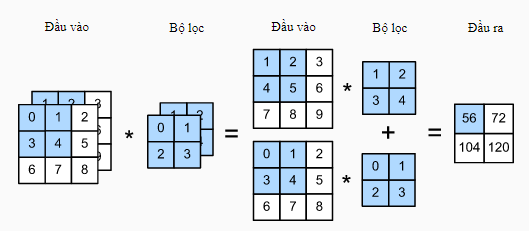



Để đảm bảo rằng chúng ta thực sự hiểu những gì đang diễn ra ở đây, chúng ta có thể tự triển khai các hoạt động tương quan chéo với nhiều kênh đầu vào. Lưu ý rằng tất cả những gì chúng ta đang làm là thực hiện thao tác tương quan chéo trên mỗi kênh và sau đó cộng các kết quả.

In [ ]:
def corr2d_multi_in(X, K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

Ta có thể tạo mảng đầu vào X và mảng bộ lọc K tương ứng với các giá trị trong hình trên để kiểm chứng kết quả đầu ra.

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

# 7.6.2. Đa kênh Đầu ra.

Cho đến nay, bất kể số lượng kênh đầu vào là bao nhiêu thì ta vẫn luôn kết thúc với chỉ một kênh đầu ra. Tuy nhiên, như đã thảo luận trước đây, hóa ra việc có nhiều kênh ở mỗi tầng là rất cần thiết. Trong các kiến trúc mạng nơ-ron phổ biến nhất, ta thường tăng kích thước chiều kênh khi tiến sâu hơn trong mạng, đồng thời giảm độ phân giải không gian để đánh đổi với chiều kênh sâu hơn này. Theo trực giác, ta có thể xem mỗi kênh tương ứng với một tập các đặc trưng khác nhau. Nhưng thực tế phức tạp hơn một chút so với cách diễn giải theo trực giác này vì các biểu diễn không được học độc lập mà được tối ưu hóa để có ích khi kết hợp với nhau. Vì vậy, có thể việc phát hiện biên sẽ được học bởi một vài kênh thay vì chỉ một kênh duy nhất.

Đặt $c_i$ và $c_o$ lần lượt là số lượng kênh đầu vào và đầu ra, $k_h$ và $k_w$ lần lượt là chiều cao và chiều rộng của bộ lọc. Để có được một đầu ra với nhiều kênh, ta có thể tạo một mảng bộ lọc có kích thước  $c_i×k_h×k_w$ cho mỗi kênh đầu ra. Ta nối chúng lại dựa trên chiều kênh đầu ra đã biết, sao cho kích thước của bộ lọc tích chập là $c_o×c_i×k_h×k_w$. Trong các phép tính tương quan chéo, kết quả trên mỗi kênh đầu ra được tính từ bộ lọc tích chập tương ứng với kênh đầu ra đó và lấy đầu vào từ tất cả các kênh trong mảng đầu vào.

Ta lập trình một hàm tương quan chéo để tính đầu ra của nhiều kênh như dưới đây.



In [ ]:
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K])

Ta tạo một bộ lọc tích chập với 3 kênh đầu ra bằng cách nối mảng bộ lọc K với K+1 (cộng một cho mỗi phần tử trong K) và K+2.

In [ ]:
K.shape

torch.Size([2, 2, 2])

In [ ]:
K = torch.stack((K, K + 1, K + 2))
K.shape

torch.Size([3, 2, 2, 2])

Dưới đây, ta thực hiện các phép tính tương quan chéo trên mảng đầu vào X với mảng bộ lọc K. Đầu ra sẽ gồm có 3 kênh. Kết quả của kênh đầu tiên khớp với kết quả trước đây khi áp dụng bộ lọc đa kênh đầu vào và một kênh đầu ra lên mảng đầu vào X.

In [ ]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

# 7.4.3. Tầng tích chập 1 X 1

Thoạt nhìn, một phép tích chập  $1×1$, tức $k_h=k_w=1$, dường như không có nhiều ý nghĩa. Suy cho cùng, một phép tích chập là để tính toán tương quan giữa các điểm ảnh liền kề. Nhưng rõ ràng một phép tích chập $1×1$ lại không làm như vậy. Mặc dù vậy, chúng là các phép tính phổ biến đôi khi được sử dụng khi thiết kế các mạng sâu phức tạp. Ta sẽ xem kỹ cách hoạt động của chúng.

Do cửa sổ có kích thước tối thiểu nên so với các tầng tích chập lớn hơn, phép tích chập  $1×1$ mất đi khả năng nhận dạng các khuôn mẫu chứa các tương tác giữa các phần tử liền kề theo chiều cao và chiều rộng. Phép tích chập $1×1$ chỉ xảy ra trên chiều kênh.

Hình dưới biểu diễn phép tính tương quan chéo sử dụng bộ lọc tích chập $1×1$ với 3 kênh đầu vào và 2 kênh đầu ra. Lưu ý rằng đầu vào và đầu ra có cùng chiều cao và chiều rộng. Mỗi phần tử trong đầu ra là một tổ hợp tuyến tính của các phần tử ở cùng một vị trí trong ảnh đầu vào. Ta có thể xem tầng tích chập $1×1$ như một tầng kết nối đầy đủ được áp dụng lên mỗi vị trí điểm ảnh đơn lẻ để chuyển đổi $c_i$ giá trị đầu vào thành  co giá trị đầu ra tương ứng. Bởi vì đây vẫn là một tầng tích chập nên các trọng số sẽ được chia sẻ giữa các vị trí điểm ảnh. Do đó, tầng tích chập $1×1$ cần tới $c_o×c_i$ trọng số (cộng thêm các hệ số điều chỉnh).

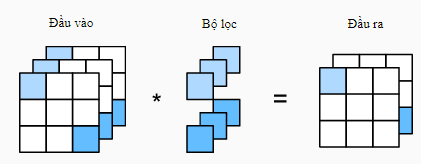

Hãy kiểm tra xem liệu nó có hoạt động trong thực tế: Ta sẽ lập trình một phép tích chập  $1×1$ sử dụng một tầng kết nối đầy đủ. Vấn đề duy nhất là ta cần phải điều chỉnh kích thước dữ liệu trước và sau phép nhân ma trận.

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

Khi thực hiện phép tích chập  $1×1$, hàm bên trên tương đương với hàm tương quan chéo đã được lập trình ở `corr2d_multi_in_out`.

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

AssertionError: ignored